In [120]:
!pip install --upgrade pip
!pip install librosa

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pip in /home/brandon/.local/lib/python2.7/site-packages (20.0.2)
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable


In [121]:
import IPython.display as ipd

import librosa

import librosa.display

import matplotlib.pyplot as plt

import numpy as np

import math

from scipy.optimize import minimize

In [122]:
piano_c5 = "Piano.ff.C5.aiff"
violin_c5 = "Violin.arco.ff.sulG.C5.stereo.aif"
ipd.Audio(piano_c5)

### Final project: My attempt to make an algorithm to differentiate piano from violin (Or other instruments possibly)
Using instrument samples downloaded from the University of Iowa.
To keep things consistent I will be using only fortissimo samples as the newer violin samples are all ff

In [123]:
piano_data,piano_sample_rate1 = librosa.load(piano_c5, sr=22050, mono=True, offset=0.0, duration=50, res_type='kaiser_best')
violin_data,violin_sample_rate1 = librosa.load(violin_c5, sr=22050, mono=True, offset=0.0, duration=50, res_type='kaiser_best')

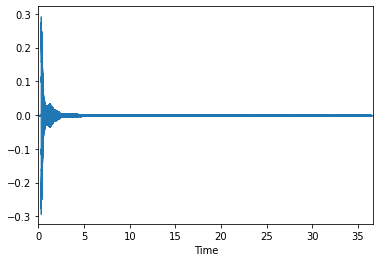

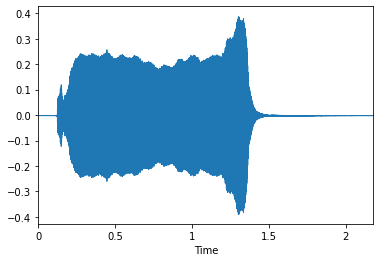

In [124]:
librosa.display.waveplot(piano_data,sr=piano_sample_rate1, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)
plt.figure()
librosa.display.waveplot(violin_data,sr=violin_sample_rate1, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)

In [125]:
def get_sample(instrument_data,offset,no_samples,compression):
    return instrument_data[offset:offset + no_samples * compression:compression]

### Get a bunch of random samples from each instrument to see what the data looks like
This bit is just trying to normalise the data and make a function to get data

In [126]:
p_compress = 1
v_compress = 1
default_compression = 1
sample_length = 300

piano_mean = np.sum(abs(piano_data))
violin_mean = np.sum(abs(violin_data))

r = (piano_mean/violin_mean)

violin_data *= r

no_samples = 5

def get_plottable_data(data,offset,no_samples,compression = 1):
    xs = np.linspace(offset,offset + no_samples * compression,no_samples)
    ys = get_sample(data,offset,no_samples,compression)
    return (xs,ys)

# Just to make it easier for me to plot
def get_plot(data,start):
    return get_plottable_data(data,start,sample_length,default_compression)

### Now just to see what the data looks like

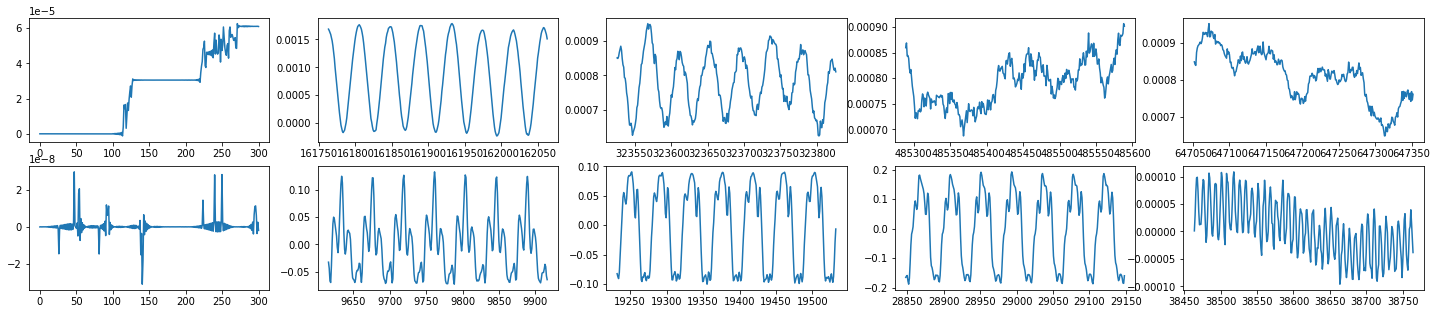

In [127]:
fig,a = plt.subplots(2,no_samples)
fig.set_size_inches(25,5)
for i in range(no_samples):
    p_location = int(len(piano_data) / no_samples) * i
    v_location = int(len(violin_data) / no_samples) * i
    p = get_plottable_data(piano_data,p_location,sample_length,p_compress)
    v = get_plottable_data(violin_data,v_location,sample_length,v_compress)
    a[0,i].plot(p[0],p[1])
    a[1,i].plot(v[0],v[1])

#### Want to get data of the note in the middle of being played
Will attempt to do this by finding a period with the most 'noise'

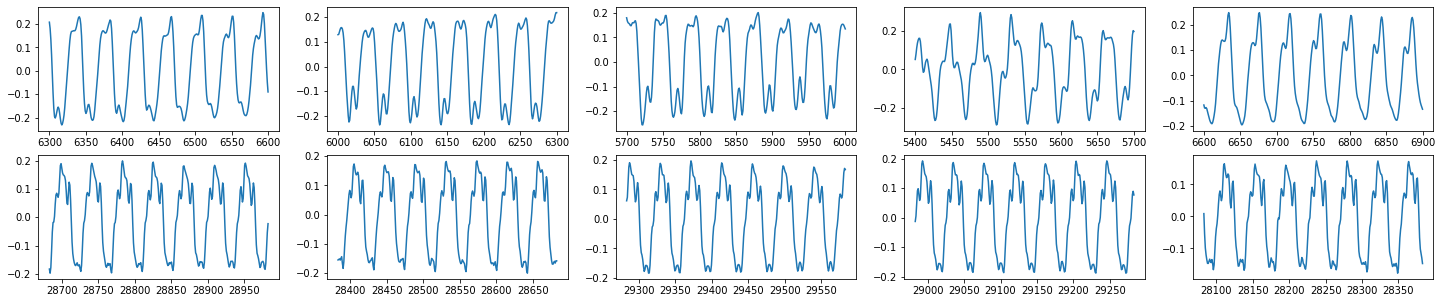

In [128]:
def get_noisiest_x(data,sample_size,no_points,compression = 1, step_skip = 1):
    def update_list(lst,n):
        if(len(lst) < no_points):
            lst.append(n)
            return True
        for i in range(len(lst)):
            if(n[0] > lst[i][0]):
                lst.insert(i,n)
                if(len(lst) > no_points):
                    lst.pop()
                return True
        return False
    noisiest = []
    d = abs(data)
    i = 0
    while i < len(data) - sample_size*compression:
        noise = np.sum(d[i:i+sample_size*compression:compression])
        if(update_list(noisiest,(noise,i))):
            i += sample_size * compression
        else:
            i += step_skip
    return [ x[1] for x in noisiest ]
#This function is horrible I never wanna see it again

p_noisiest = get_noisiest_x(piano_data,sample_length,no_samples,p_compress)
v_noisiest = get_noisiest_x(violin_data,sample_length,no_samples,v_compress)
fig,a = plt.subplots(2,no_samples)
fig.set_size_inches(25,5)
piano_samples = []
violin_samples = []
for i in range(len(p_noisiest)):
    p = get_plottable_data(piano_data,p_noisiest[i],sample_length,p_compress)
    v = get_plottable_data(violin_data,v_noisiest[i],sample_length,v_compress)
    piano_samples.append(p)
    violin_samples.append(v)
    a[0,i].plot(p[0],p[1])
    a[1,i].plot(v[0],v[1])

Surprisingly worked pretty well.

### Now to get discrete fourier transform for the samples


(0.0, 2000.0)

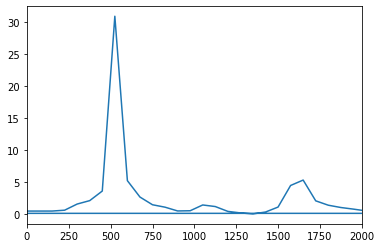

In [129]:
framerate = 22500

fourier = np.fft.fft(piano_samples[0][1])
freq = np.fft.fftfreq(len(piano_samples[0][1])) * 22500
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq,np.abs(fourier))
ax.set_xlim(0,2000)

## Sample size is too small in this example (Uncertainty principle)
Sample size I used was way too small and resulted in a 'wide' fourier graph. To fix this I need a bigger sample size.
First ill get the 'best' place to collect samples. Here I will collect data from 10000 points from the piano sample

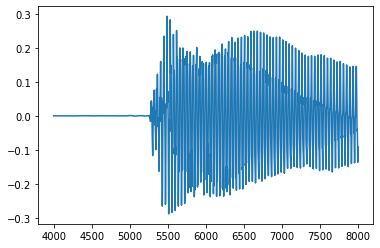

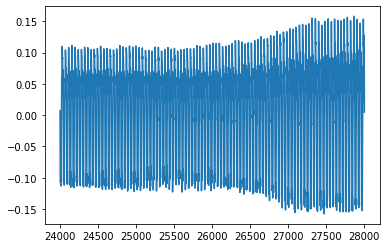

In [130]:
long_sample_length = 4000

p_good_pos = get_noisiest_x(piano_data,long_sample_length,1)
p = get_plottable_data(piano_data,p_good_pos[0],long_sample_length,1)
v_good_pos = get_noisiest_x(violin_data,long_sample_length,1)
v = get_plottable_data(violin_data,v_good_pos[0],long_sample_length,1)
plt.plot(p[0],p[1])
plt.figure()
plt.plot(v[0],v[1])

(0.0, 2000.0)

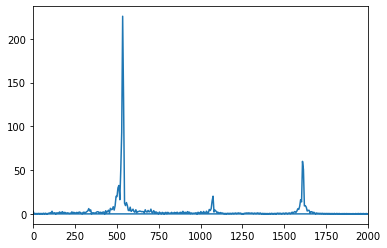

In [131]:
pf = np.fft.fft(p[1])
freq = np.fft.fftfreq(len(p[1])) * framerate
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq,np.abs(pf))
ax.set_xlim(0,2000)

## Wow! looks much better
Since the sample I used was a piano playing middle c (freq = 523.25 hertz) we have a huge spike at roughly 520 hertz

## Now to compare violin and piano side by side

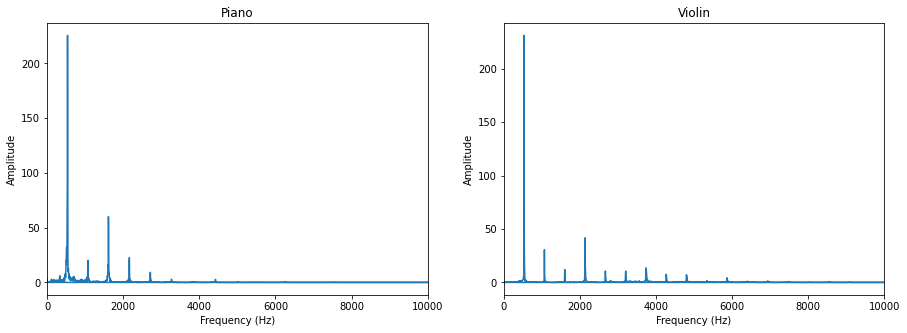

In [132]:
vf = np.fft.fft(v[1])
fig,a = plt.subplots(1,2)
fig.set_size_inches(15,5)
a[0].set_xlim(0,10000)
a[0].set_ylabel("Amplitude")
a[0].set_xlabel("Frequency (Hz)")
a[0].set_title("Piano")
a[0].plot(freq,np.abs(pf))

a[1].set_xlim(0,10000)
a[1].set_ylabel("Amplitude")
a[1].set_xlabel("Frequency (Hz)")
a[1].set_title("Violin")
a[1].plot(freq,np.abs(vf))

The piano seems to have a lot of traces of other frequencies mixed into it. I need to find out if its consistent across more samples

### Now to try more notes

In [133]:
def load_from_file(piano,violin):
    p_data,p_sample_rate = librosa.load(piano, sr=22050, mono=True, offset=0.0, duration=50, res_type='kaiser_best')
    v_data,v_sample_rate = librosa.load(violin, sr=22050, mono=True, offset=0.0, duration=50, res_type='kaiser_best')
    piano_mean = np.sum(abs(p_data))
    violin_mean = np.sum(abs(v_data))

    r = (piano_mean/violin_mean)
    v_data *= r
    
    return (p_data,v_data)

def get_fourier(data,sample_size):
    good_pos = get_noisiest_x(data,sample_size,1)
    d = get_plottable_data(data,good_pos[0],sample_size)
    f = np.fft.fft(d[1])
    fre = np.fft.fftfreq(len(p[1])) * framerate
    return (fre,f)
    
f_p,f_v = load_from_file("Piano.ff.F4.aiff","Violin.arco.ff.sulG.F4.stereo.aif")
g_p,g_v = load_from_file("Piano.ff.G4.aiff","Violin.arco.ff.sulG.G4.stereo.aif")
a_p,a_v = load_from_file("Piano.ff.A4.aiff","Violin.arco.ff.sulG.A4.stereo.aif")
b_p,b_v = load_from_file("Piano.ff.B4.aiff","Violin.arco.ff.sulG.B4.stereo.aif")
c_p,c_v = load_from_file("Piano.ff.C5.aiff","Violin.arco.ff.sulG.C5.stereo.aif")

In [134]:
fpf = get_fourier(f_p,long_sample_length)
fvf = get_fourier(f_v,long_sample_length)
gpf = get_fourier(g_p,long_sample_length)
gvf = get_fourier(g_v,long_sample_length)
apf = get_fourier(a_p,long_sample_length)
avf = get_fourier(a_v,long_sample_length)
bpf = get_fourier(b_p,long_sample_length)
bvf = get_fourier(b_v,long_sample_length)
cpf = get_fourier(c_p,long_sample_length)
cvf = get_fourier(c_v,long_sample_length)

Also here im getting the fundamental frequency so later on we wont lose the peaks position if the note is played at a slightly different frequency

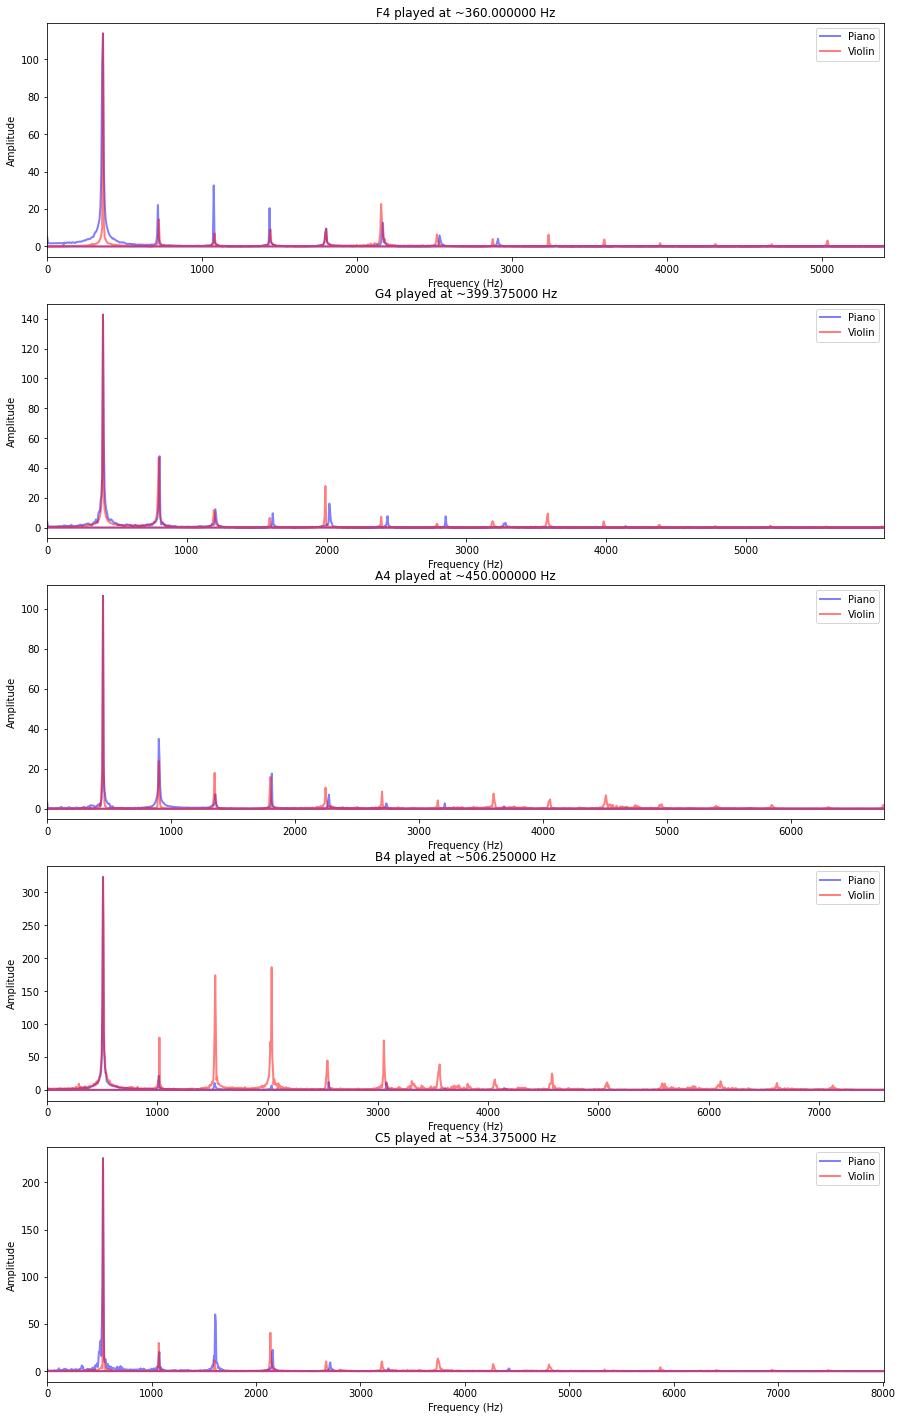

In [135]:
def get_fun_freq(fourier_data):
    return abs(fourier_data[0][np.argmax(np.abs(fourier_data[1]))])

def plot(p,p_data,v_data,title, octaves = 15):
    pf = get_fun_freq(p_data)
    vf = get_fun_freq(v_data)
    f = (pf + vf)/2
    p.set_xlim(0,f * octaves)
    p.set_ylabel("Amplitude")
    p.set_xlabel("Frequency (Hz)")
    p.set_title(title + " played at ~%f Hz" % f)
    pys = np.abs(p_data[1])
    vys = np.abs(v_data[1])
    r = np.max(pys)/np.max(vys)
    vys *= r
    p.plot(p_data[0],pys,color='blue',alpha=0.5,label="Piano", linewidth=2)
    p.plot(v_data[0],vys,color='red',alpha=0.5,label="Violin", linewidth=2)
    p.legend()

fig,a = plt.subplots(5,1)
fig.set_size_inches(15,25)
plot(a[0],fpf,fvf,"F4") #F4 freq ~ 350 Hz
plot(a[1],gpf,gvf,"G4") #G4 freq ~ 392 Hz
plot(a[2],apf,avf,"A4") #A4 freq ~ 440 Hz
plot(a[3],bpf,bvf,"B4") #B4 freq ~ 494 Hz
plot(a[4],cpf,cvf,"C5") #C5 freq ~ 523 Hz

The violin has much more peaks than the piano. Also the piano peaks seem to get further and further behind the violin peaks. I will try to get the location of the peaks

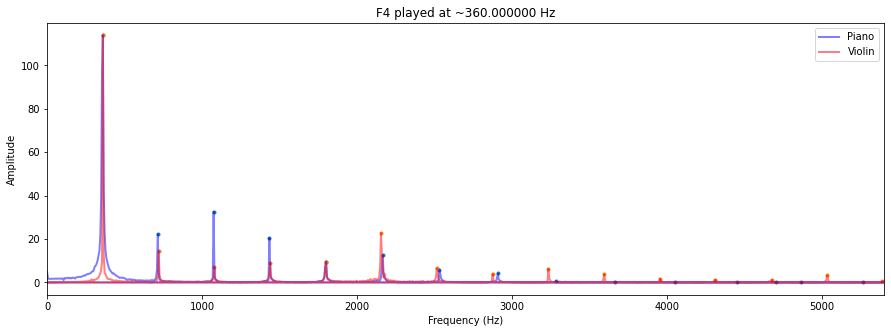

In [136]:
from scipy.signal import find_peaks

def normalise(lst1,lst2):
    l = max(lst1)
    r = max(lst2)
    return (lst1,lst2 * l/r)

def get_peaks(fourier_data,octaves = 15):
    pks = []
    f = get_fun_freq(fourier_data)
    xs = fourier_data[0];
    ys = np.abs(fourier_data[1])
    for i in range(octaves):
        gt = xs > f * i + (f/2)
        lt = xs < f * (i+1) + (f/2)
        x = xs[gt&lt]
        y = ys[gt&lt]
        mi = np.argmax(y)
        pks.append((x[mi],y[mi]))
    pks = np.array(pks)
    srted = pks[:,0].argsort()
    srtdpks = pks[srted]
    return np.array(srtdpks)
    
fig,a = plt.subplots(1,1)
fig.set_size_inches(15,5)
fpp = get_peaks(fpf)
fvp = get_peaks(fvf)
fpy,fvy = normalise(fpp[:,1],fvp[:,1])
a.plot(fpp[:,0],fpy,'.')
a.plot(fvp[:,0],fvy,'.')
plot(a,fpf,fvf,"F4")

This function mostly works as I can expect that the peaks will appear at some multiple of the frequency. Its also much simpler than a gradient descent/minimisation problem.

Now to get data for all the notes being played

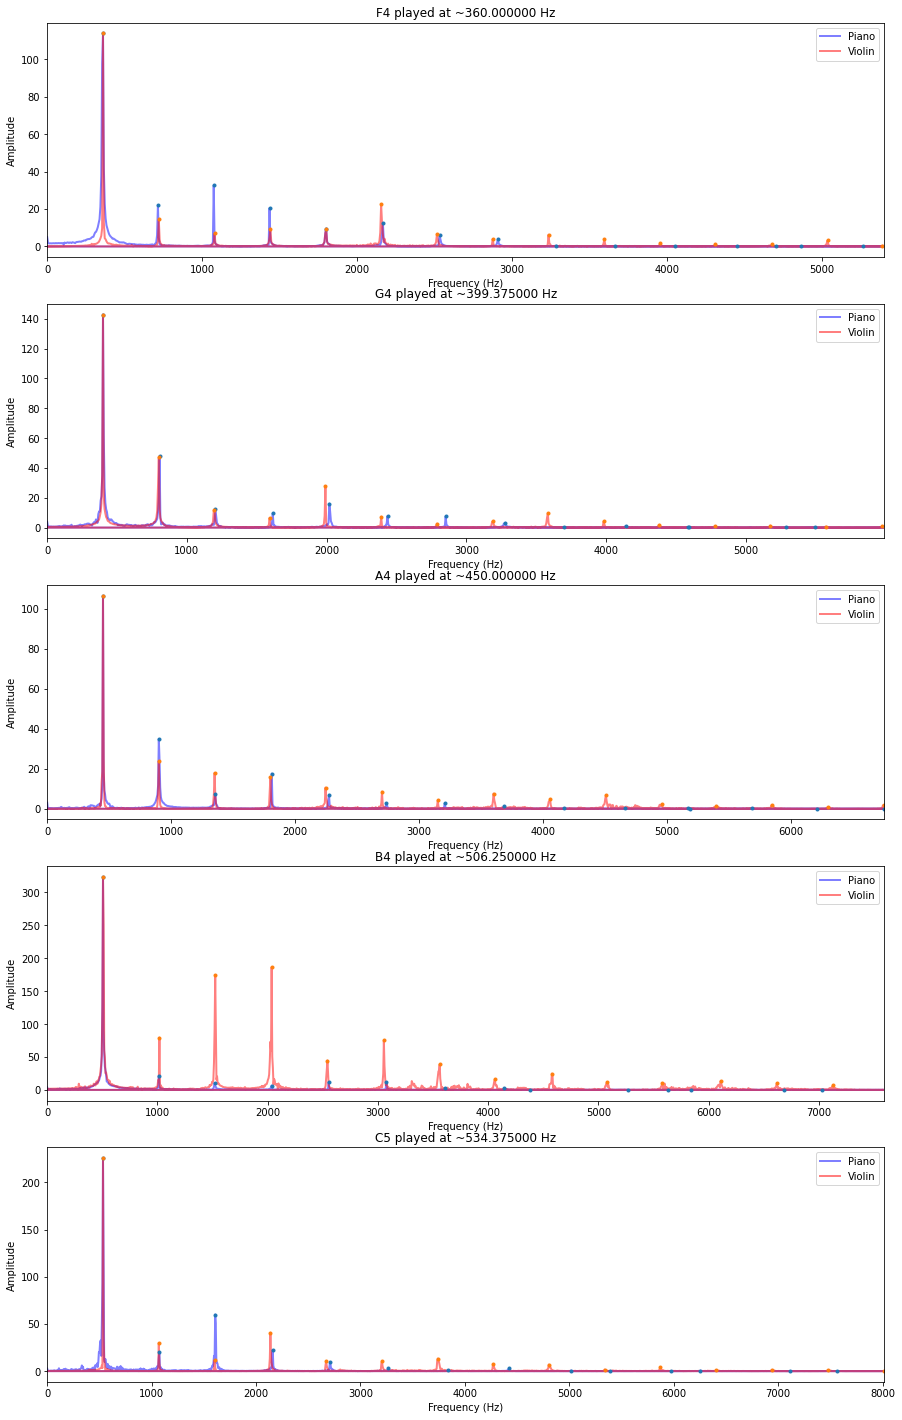

In [137]:
def plot_peaks(p,p_data,v_data):
    pp = get_peaks(p_data)
    vp = get_peaks(v_data)
    npy, nvy = normalise(pp[:,1],vp[:,1])
    p.plot(pp[:,0],npy,'.')
    p.plot(vp[:,0],nvy,'.')

fig,a = plt.subplots(5,1)
fig.set_size_inches(15,25)
plot(a[0],fpf,fvf,"F4") #F4 freq ~ 350 Hz
plot_peaks(a[0],fpf,fvf)
plot(a[1],gpf,gvf,"G4") #G4 freq ~ 392 Hz
plot_peaks(a[1],gpf,gvf)
plot(a[2],apf,avf,"A4") #A4 freq ~ 440 Hz
plot_peaks(a[2],apf,avf)
plot(a[3],bpf,bvf,"B4") #B4 freq ~ 494 Hz
plot_peaks(a[3],bpf,bvf)
plot(a[4],cpf,cvf,"C5") #C5 freq ~ 523 Hz
plot_peaks(a[4],cpf,cvf)

I will try to find the line that represents the 'expected amplitude' of each peak.

First I will try to find the 'expected amplitude' for each peak respective to the peak. This will be a value between 0 and 1

In [138]:
p_fourier = [ fpf,gpf,apf,bpf,cpf ]
v_fourier = [ fvf, gvf, avf, bvf, cvf ]

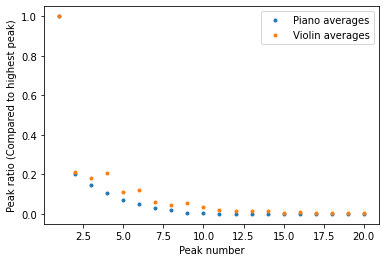

In [142]:
def get_amps(instr_fourier,octaves = 15):
    peaks = get_peaks(instr_fourier,octaves)
    mpeak = max(peaks[:,1])
    ratios = []
    for p in peaks:
        ratios.append(p[1]/mpeak)
    return ratios

p_ratios = np.array([ get_amps(p,20) for p in p_fourier ])
v_ratios = np.array([ get_amps(v,20) for v in v_fourier ])

p_avg_ratio = []
v_avg_ratio = []
for i in range(20):
    p_avg_ratio.append(np.mean(p_ratios[:,i]))
    v_avg_ratio.append(np.mean(v_ratios[:,i]))
    
xs = np.linspace(1,20,20)
fig,a = plt.subplots(1)
a.plot(xs,p_avg_ratio,'.',label="Piano averages")
a.plot(xs,v_avg_ratio,'.', label="Violin averages")
a.set_xlabel("Peak number")
a.set_ylabel("Peak ratio (Compared to highest peak)")
a.legend()

It would probably be better to use more data to get more accurate averages but for now this'll do for visualising the shape of the line

Looks like we may be able to represent it using the function

$$
    y = ab^\frac{1}{x} + c
$$

We can also see that piano ratios are also underneath the violin ratios

[ 0.14854212  7.79375633 -0.15962196]


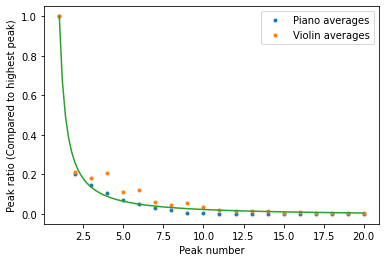

In [145]:
def pkf(x,octaves = 20):
    s = 0
    for i in range(octaves):
        line = x[0] * x[1] ** (1/(i+1)) + x[2]
        for p in p_ratios[:,i]:
            d = (p - line)**2
            if(p <= line):
                s
            else:
                s += d
        for v in v_ratios[:,i]:
            d = (v - line) ** 2
            if(v >= line):
                s
            else:
                s += d
    return s

testScores = np.array([1 for i in range(15)])

m = minimize(pkf,(1,1,1))
print(m.x)

def score_f(x):
    return m.x[0] * m.x[1] ** (1/x) + m.x[2]

xs = np.linspace(1,20,20)
axs = np.linspace(1,20,100)
ys = [ score_f(xx) for xx in axs ]
fig,a = plt.subplots(1)
a.plot(xs,p_avg_ratio,'.',label="Piano averages")
a.plot(xs,v_avg_ratio,'.', label="Violin averages")
a.plot(axs,ys)
a.set_xlabel("Peak number")
a.set_ylabel("Peak ratio (Compared to highest peak)")
a.legend()

Now that we have a dividing line we can sum up the peak ratios and if its above the line we can assume its a violin. If its under we can assume its a piano. I will test it on the piano samples and violin samples I collected

In [146]:
yps = [ score_f(xx) for xx in xs ]
def what_ins(peaks):
    s = 0
    for i in range(len(yps)):
        if(peaks[i] > yps[i]):
            s += 1
    if(s > len(peaks)/2):
        return "Violin"
    else:
        return "Piano"

for i in p_ratios:
    print(what_ins(i))
for i in v_ratios:
    print(what_ins(i))

Piano
Piano
Piano
Piano
Piano
Violin
Piano
Violin
Violin
Piano


We only trained it on 10 samples and it was right 8/10 times. Maybe thats a win?
This doesnt account for the peak frequency shift that you could see for the piano and violin peaks though. If i